# <u>Fetal Health: A Quick Guide to High Accuracy! </u>
## <br> Author: Christopher W. Smith </br>
<br>Unfinished, Updated:10/14/2020 </br>

<br> <i>linkdin</i>: www.linkedin.com/in/christopher-w-smith022 </br>

<br> The purpose of this notebook is to classify the differences of fetal health based on different test results values. I skipped over most EDA as there is a lot of values and moved directly too feature importance and selected features by ANOVA F-ratio. Then I used, support vector machines (SVM), Random Forest Classier and Multi-Layer Perceptron with hyper parameterization by grid and randomized searchers for the most accurately built models. From here I plan to see if I can reach 100% by applying either linear discriminant analysis or principal component analysis as another pre-processing steps after feature selection. Current highest score is 94% accuracy.</br>

Kaggle link: https://www.kaggle.com/andrewmvd/fetal-health-classification
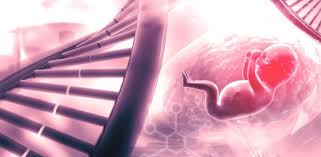

# Importing Relevant General Packages

In [ ]:
!pip install seaborn --upgrade #Update Seaborn for Plotting

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno #Visualize null

#Plotting Functions
import matplotlib.pyplot as plt

#Aesthetics
import seaborn as sns
sns.set_style('ticks') #No grid with ticks
print(sns.__version__)

## Importing the Data

In [ ]:
#Data Import
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
fetal=pd.read_csv('/kaggle/input/fetal-health-classification/fetal_health.csv')
fetal.info()
fetal.head()

There are no null values and all the data besides fetal_health which is our target are floats. Therefore, we will quickly asses if we have any replicates then move into brief EDA.

In [ ]:
#Dropping duplicates
fetal_dup=fetal.copy()
fetal_dup.drop_duplicates(inplace=True)
print('Total number of replicates are:', fetal.shape[0] - fetal_dup.shape[0])
fetal=fetal_dup.copy()
fetal

Replicates were removed lets do brief EDA.
# Exploratory Data Analysis
There are a ton of variables so lets not get caught up looking at all combinations. Instead lets just make sure our data is relatively balanced. First I will set a plotting function that makes publication ready figures then I will plot a count plot.

## Plotter

In [ ]:
def Plotter(plot, x_label, y_label, x_rot=None, y_rot=None,  fontsize=12, fontweight=None, legend=None, save=False,save_name=None):
    """
    Helper function to make a quick consistent plot with few easy changes for aesthetics.
    Input:
    plot: sns or matplot plotting function
    x_label: x_label as string
    y_label: y_label as string
    x_rot: x-tick rotation, default=None, can be int 0-360
    y_rot: y-tick rotation, default=None, can be int 0-360
    fontsize: size of plot font on axis, defaul=12, can be int/float
    fontweight: Adding character to font, default=None, can be 'bold'
    legend: Choice of including legend, default=None, bool, True:False
    save: Saves image output, default=False, bool
    save_name: Name of output image file as .png. Requires Save to be True.
               default=None, string: 'Insert Name.png'
    Output: A customized plot based on given parameters and an output file
    
    """
    #Ticks
    ax.tick_params(direction='out', length=5, width=3, colors='k',
               grid_color='k', grid_alpha=1,grid_linewidth=2)
    plt.xticks(fontsize=fontsize, fontweight=fontweight, rotation=x_rot)
    plt.yticks(fontsize=fontsize, fontweight=fontweight, rotation=y_rot)

    #Legend
    if legend==None:
        pass
    elif legend==True:
        
        plt.legend()
        ax.legend()
        pass
    else:
        ax.legend().remove()
        
    #Labels
    plt.xlabel(x_label, fontsize=fontsize, fontweight=fontweight, color='k')
    plt.ylabel(y_label, fontsize=fontsize, fontweight=fontweight, color='k')

    #Removing Spines and setting up remianing, preset prior to use.
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(3)
    
    if save==True:
        plt.savefig(save_name)

In [ ]:
fig, ax=plt.subplots()#Required outside of function. This needs to be activated first when plotting in every code block
plot=sns.countplot(data=fetal, x='fetal_health', hue='fetal_health', palette=['b','r','g'])#count plot
Plotter(plot, 'fetal_health level', 'count', legend=True, save=True, save_name='fetal health count.png')#Plotter function for aesthetics
plot

Clearly, the data is imbalanced and I do not plan on performing an upsample till intial modeling is complete. Instead of plotting a pair plot, we can plot a correlation matrix to observe the pearson correlation coefficients. Remember though that correlation does not imply causation. This will also guide us to predicting what the feature selection (KBest) will decide are the most important features as well later.

In [ ]:
fig, ax=plt.subplots(figsize=(12,12))#Required outside of function. This needs to be activated first when plotting in every code block
plot=sns.heatmap(fetal.corr(),annot=True, cmap='Blues', linewidths=1)
Plotter(plot, None, None, 90,legend=False, save=True, save_name='Corr.png')

First I will find the most important features using the KBest Alogirthm with f_classif. The correlation coefficients can aid in explaining the importances in the features importance.

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest #Feature Selector
from sklearn.feature_selection import f_classif #F-ratio statistic for categorical values

In [ ]:
#Feature Selection
X=fetal.drop(['fetal_health'], axis=1)
Y=fetal['fetal_health']
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns

#Visualize the feature scores
fig, ax=plt.subplots(figsize=(7,7))
plot=sns.barplot(data=featureScores, x='Score', y='Feature', palette='viridis',linewidth=0.5, saturation=2, orient='h')
Plotter(plot, 'Score', 'Feature', legend=False, save=True, save_name='Feature Importance.png')#Plotter function for aesthetics
plot

We will take all the features that scored more than 200 as they show the least redundancy.

In [ ]:
#Selection method
selection=featureScores[featureScores['Score']>=200]#Selects features that scored more than 200
selection=list(selection['Feature'])#Generates the features into a list
selection.append('fetal_health')#Adding the Level string to be used to make new data frame
new_fetal=fetal[selection] #New dataframe with selected features
new_fetal.head() #Lets take a look at the first 5

We were left with 6 features that were selected as the most important. Since we have a reduced feature amount lets plot a quick pairplot to spot some differences. 

In [ ]:
new_name_fetal=new_fetal.rename(columns = {'percentage_of_time_with_abnormal_long_term_variability':'%_ab_long_var', 
                                           'abnormal_short_term_variability': 'short_var'}) #Reduce the size of names for plotting
sns.pairplot(new_name_fetal, hue='fetal_health')

Looks like 1 and 3 can be well distinguished from eachother at least and 2 may be tougher. Lets start the process for machine learning.

# Splitting the data and Scaling
First, the data will be split so we can train a scaler model to apply to an unknwon (test) data set. We will save 25% of the data for testing. The data will then be split by standard scaler using the formula $z=\frac{X_{o}-\mu}{\sigma}$. This can help reduce the effect of outliers when modeling later. As per the task, stratify will be used. Spoiler: Highest achieved accuracy without stratify was 95% with RFC.

In [ ]:
#Splitting
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(fetal.drop(['fetal_health'], axis=1), fetal['fetal_health'],test_size=0.30, random_state=0, 
                                                 stratify=fetal['fetal_health'])

#Checking the shapes
print("X_train shape :",X_train.shape)
print("Y_train shape :",y_train.shape)
print("X_test shape :",X_test.shape)
print("Y_test shape :",y_test.shape)

#Scaling
from sklearn import preprocessing
scaler=preprocessing.StandardScaler()

X_train_scaled=scaler.fit_transform(X_train) #Scaling and fitting the training set to a model
X_test_scaled=scaler.transform(X_test) #Transformation of testing set based off of trained scaler model

Now that the data is split and scaled we can begin modeling.
# Machine Learning with Classifiers and Grid/Randomization Search
For modeling we will use a few different classifiers.  We can evalute multiple parameters at one using Grid or Randomization Search functions. Grid Search evalutes several input parameters at all combinations input while randomized search looks for the best. Cross-validation is the models self assemessment when trying to find the best parameters on the training data and can be done in "n" amount of replicates. We will set up two functions: one for the searches and the other for the confusion matrices.

In [ ]:
#Packages for metrics and search
"""These packages are required for the functions below
"""
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV #Paramterizers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix #Accuracy metrics
import itertools #Used for iterations

## Search Function
(Read red indents below def function for understanding of code)

In [ ]:
def Searcher(estimator, param_grid, search, train_x, train_y, test_x, test_y,label=None,cv=10):
    """
    This is a helper function for tuning hyperparameters using the two search methods.
    Methods must be GridSearchCV or RandomizedSearchCV.
    Inputs:
        estimator: Any Classifier
        param_grid: Range of parameters to search
        search: Grid search or Randomized search
        train_x: input variable of your X_train variables 
        train_y: input variable of your y_train variables
        test_x: input variable of your X_test variables
        test_y: input variable of your y_test variables
        label: str to print estimator, default=None
        cv: cross-validation replicates, int, default=10
    Output:
        Returns the estimator instance, clf
        
    Modified from: https://www.kaggle.com/crawford/hyperparameter-search-comparison-grid-vs-random#To-standardize-or-not-to-standardize
    
    """   
    
    try:
        if search == "grid":
            clf = GridSearchCV(
                estimator=estimator, 
                param_grid=param_grid, 
                scoring=None,
                n_jobs=-1, 
                cv=cv, #Cross-validation at 10 replicates
                verbose=0,
                return_train_score=True
            )
        elif search == "random":           
            clf = RandomizedSearchCV(
                estimator=estimator,
                param_distributions=param_grid,
                n_iter=10,
                n_jobs=-1,
                cv=cv,
                verbose=0,
                random_state=1,
                return_train_score=True
            )
    except:
        print('Search argument has to be "grid" or "random"')
        sys.exit(0) #Exits program if not grid or random
        
    # Fit the model
    print('Start model fitting for', label)
    clf.fit(X=train_x, y=train_y)
    
    #Testing the model
    
    try:
        if search=='grid':
            cfmatrix=confusion_matrix(
            y_true=test_y, y_pred=clf.predict(test_x))
        
            #Defining prints for accuracy metrics of grid
            print("**Grid search results of", label,"**")
            print("The best parameters are:",clf.best_params_)
            print("Best training accuracy:\t", clf.best_score_)
            print('Classification Report:')
            print(classification_report(y_true=test_y, y_pred=clf.predict(test_x))
             )
        elif search == 'random':
            cfmatrix=confusion_matrix(
            y_true=test_y, y_pred=clf.predict(test_x))

            #Defining prints for accuracy metrics of grid
          
            print("**Random search results of", label,"**")
            print("The best parameters are:",clf.best_params_)
            print("Best training accuracy:\t", clf.best_score_)
            print('Classification Report:')
            print(classification_report(y_true=test_y, y_pred=clf.predict(test_x))
             )
    except:
        print('Search argument has to be "grid" or "random"')
        sys.exit(0) #Exits program if not grid or random
        
    return clf, cfmatrix; #Returns a trained classifier with best parameters

## Confusion Matrix Function 
(Read red indents below def function for understanding of code)

In [ ]:
def plot_confusion_matrix(cm, label,color=None,title=None):
    """
    Plot for Confusion Matrix:
    Inputs:
        cm: sklearn confusion_matrix function for y_true and y_pred as seen in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
        title: title of confusion matrix as a 'string', default=None
        label: the unique label that represents classes for prediction can be done as sorted(dataframe['labels'].unique()).
        color: confusion matrix color, default=None, set as a plt.cm.color, based on matplot lib color gradients
    """
    
    classes=sorted(label)
    plt.imshow(cm, interpolation='nearest', cmap=color)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black")

## Modeling
We will start with support vector machines. Using the support vector machines classifiers (SVC) it can handle higher dimensional data and generate hyperplanes for separation and score on a yes (1) no (1) basis. The rulings are decided for where a data point lands within a decision boundary. F-1 score provides us with a method to monitor the precision and recall of our values.

In [ ]:
from sklearn.svm import SVC #Support Vector Classifier

#Grid Search SVM Parameters
svm_param = {
    "C": [.01, .1, 1, 5, 10, 100], #Specific parameters to be tested at all combinations
    "gamma": [0, .01, .1, 1],
    "kernel": ["rbf","linear","poly"],
    "degree": [3,4],
    "random_state": [1]}

#Randomized Search SVM Parameters
svm_dist = {
    "C": np.arange(0.01,100, 0.01),   #By using np.arange it will select from randomized values
    "gamma": np.arange(0,1, 0.01),
    "kernel": ["rbf","linear","poly"],
    "degree": [3,4],
    "random_state": [1]}

"""
Following the code above, we can set the parameters for both grid search and randomized search. The grid search will evaluate all specified 
parameters while the randomized search will look at the parameters labeled in random order at the best training accuracy. The np.arange function
allows for a multitude of points to be looked at between the set start and end values of 0.01 to 1. """

#Grid Search SVM
svm_grid, cfmatrix_grid= Searcher(SVC(), svm_param, "grid", X_train_scaled, y_train, X_test_scaled, y_test,label='SVC Grid')

print('_____'*20)#Spacer

#Random Search SVM
svm_rand, cfmatrix_rand= Searcher(SVC(), svm_dist, "random", X_train_scaled, y_train, X_test_scaled, y_test,label='SVC Random')

#Plotting the confusion matrices
plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title='Random Search Confusion Matrix',label=fetal['fetal_health'].unique(), color=plt.cm.cividis) #grid matrix function
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title='Grid Search Confusion Matrix', label=fetal['fetal_health'].unique(), color=plt.cm.cividis) #randomized matrix function

## Random Forest
An ensemble method that estimates several weak decision trees and combines the mean to create an uncorrelated forest at the end. The uncorrelated forest should be able to predict more accurately than an individual tree.

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

#Grid Search RFC Parameters
rfc_param = {
    "n_estimators": [10, 50, 75, 100, 150,200], #Specific parameters to be tested at all combinations
    "criterion": ['entropy','gini'],
    "random_state": [1],
    "max_depth":np.arange(1,16,1)}

#Randomized Search RFC Parameters
rfc_dist = {
    "n_estimators": np.arange(10,200, 10),   #By using np.arange it will select from randomized values
    "criterion": ['entropy','gini'],
    "random_state": [1],
    "max_depth":np.arange(1,16,1)}

#Grid Search RFC
rfc_grid, cfmatrix_grid= Searcher(RFC(), rfc_param, "grid", X_train_scaled, y_train, X_test_scaled, y_test,label='RFC Grid')

print('_____'*20)#Spacer

#Random Search RFC
rfc_rand, cfmatrix_rand= Searcher(RFC(), rfc_dist, "random", X_train_scaled, y_train, X_test_scaled, y_test,label='RFC Random')

#Plotting the confusion matrices
plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title='Random Search Confusion Matrix',label=fetal['fetal_health'].unique(), color=plt.cm.cividis) #grid matrix function
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title='Grid Search Confusion Matrix', label=fetal['fetal_health'].unique(), color=plt.cm.cividis) #randomized matrix function

## Multi-Layer Perceptron
Feed-forward neural network. Very simple compared to using tensor flow or keras,however, may not be as powerful. The number of nodes are determined by (2/3 * input feature count) + (number of output + 2). The number of layers were decided by 2/3 of the first and 1/2 the second layer. We can paramterize plenty of activator functions and set this up with the search function above. Running the searches with this code may take about 30-60min.

In [ ]:
from sklearn.neural_network import MLPClassifier as MLP

#Grid Search MLP Parameters
mlp_param = {
    "hidden_layer_sizes": [(6,),(6,4),(6,4,2)], #Specific parameters to be tested at all combinations
    "activation": ['identity', 'logistic', 'tanh', 'relu'],
    "max_iter":[200,400,600,800,1000],
    "solver":['lbfgs', 'sgd', 'adam'],
    "learning_rate_init":[0.001],
    "learning_rate":['constant','adaptive'],
    "random_state": [1]}

#Randomized Search MLP Parameters
mlp_dist = {
    "hidden_layer_sizes": [(6,),(6,4),(6,4,2)], #Specific parameters to be tested at all combinations
    "activation": ['identity', 'logistic', 'tanh', 'relu'],
    "max_iter":np.arange(100,1000, 100),
    "solver":['lbfgs', 'sgd', 'adam'],
    "learning_rate_init":[0.001],
    "learning_rate":['constant','adaptive'],
    "random_state": [1]}


#Grid Search SVM
rfc_grid, cfmatrix_grid= Searcher(MLP(), mlp_param, "grid", X_train_scaled, y_train, X_test_scaled, y_test,label='MLP Grid')

print('_____'*20)#Spacer

#Random Search SVM
rfc_rand, cfmatrix_rand= Searcher(MLP(), mlp_dist, "random", X_train_scaled, y_train, X_test_scaled, y_test,label='MLP Random')

#Plotting the confusion matrices
plt.subplots(1,2)
plt.subplots_adjust(left=-0.5, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plot_confusion_matrix(cfmatrix_rand, title='Random Search Confusion Matrix',label=fetal['fetal_health'].unique(), color=plt.cm.cividis) #grid matrix function
plt.subplot(121)
plot_confusion_matrix(cfmatrix_grid, title='Grid Search Confusion Matrix', label=fetal['fetal_health'].unique(), color=plt.cm.cividis) #randomized matrix function

Interestingly, even with imbalanced data all models scored relatively well with random forest performing the best.

# Conclusion
We observed that:
* Using KBestSelection we were able to use the most important features from the data set
* The 6 selected features provided 100% accuracy when modeled with either Grid/Randomized Searches on SVM, RFC or MLP classifiers.
* RFC impressingly on an imbalanced data set performed at nearly 95% testing accuracy.
* Maybe using reduction techniques as a preprocessing step may aid in separating the data.

# Next Steps
* Compare PCA and LDA dimension reduction techniques in attempt to further separate the data.
* Re-train models on dimensionally reduced data for comparison.
* Re-apply upsampling if neccessary.

<b>Suggestions?

If you stuck around to the end please leave a comment for feedback or upvote!</b>

Like what I have done? Check out my other notebooks here: https://www.kaggle.com/christopherwsmith

# Selected Notebooks That Are Helpful!
* https://www.kaggle.com/christopherwsmith/classify-that-penguin-100-accuracy

* https://www.kaggle.com/christopherwsmith/tutorial-quick-custom-and-helpful-functions

* https://www.kaggle.com/christopherwsmith/how-to-predict-lung-cancer-levels-100-accuracy